In [63]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

In [64]:
#coleta de dados

df = pd.read_excel("./titanic3.xls")
orig_df = df

In [65]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [66]:
#descricao dos dados resumido
df.describe().iloc[:,:2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [67]:
#relatório de dados nulos
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [68]:
#relatório de dados nulos em %
df.isnull().mean()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

In [69]:
#ralatório dos dados aprofundado
import ipywidgets
import pandas_profiling
pandas_profiling.ProfileReport(df)

Render HTML: 100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


In [70]:
#Analise de colunas do tipo obejct(string)
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [71]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [72]:
#Criando e dropando atributos
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [73]:
#descartando colunas nao essenciais para o modelo e colunas que identificam se a pessoa sobreviveu ou nao(para evitar o boicote do modelo pelo vazemento de informação de sobrevivência )
df = df.drop(
    columns=[
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ]
)

In [74]:
#Criação de variáveis dummy para as colunas object de sexo e embarcação
df = pd.get_dummies(df)
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [75]:
#como no caso da coluna de sex_male e sex_female haver uma correlacao perfeita em que se um atributo valer um outro automaticamente valera 0, isso impacta negativamente na multicolinearidade do modelo, uma correlacao desnecessaria
#dropando parte da correlação perfeita
df = df.drop(columns="sex_male")
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [76]:
#sabendo que o aprendizdo de maquina supervisionado(regressa-> gera numeros continuos/classificação->gera rotulos)
# dada por sua representacao formular algebrica de y = f(X) em y é  a saida da funcao que seria a predicao contendo
# os rotulos e a os numeros de regressao e X é a matriz de dados(Dataframe)
y = df.survived
X = df.drop(columns="survived")

In [77]:
#separando amostras de tarino e teste
#treinamento e testes em dados distintos -> usando o scikit-learn para extrair 30 % dos dados para teste
# usando o random_state = 42 para eliminar a aleatoridade  e poder comparar diferentes modelos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [78]:
#Fazendo inputação dos dados ausentes
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import enable_iterative_impute
num_cols = [
    "pclass",
    "age",
    "sibsp",
    "fare",
    "sex_female",
]

imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(
    X_train[num_cols]
)

X_train.loc[:,num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:,num_cols] = imputed
 
# poderia inputar também usando a mediana pelo pandas
"""
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)
""" 

ImportError: cannot import name 'enable_iterative_impute' from 'sklearn' (C:\Users\gusta\AppData\Roaming\Python\Python37\site-packages\sklearn\__init__.py)

In [ ]:
#Normalizar/Pré-processar os dados 
#Pradronização dos dados de modo que tenha uma valor de média = 0 e um desvio padrão = 1
#Por boa prática as colunas dummy não serão padronizadas
cols = "pclass,age,sibsp,fare".split(",")
sca = preprocessing.StandardScaler()

X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns= cols)

In [ ]:
#Reafatorando o código
#Uma função de limpeza geral e outra de divisão entre conjunto de treinamente e conjunto de testes
def tweak_titanic(df):
    df = df.drop(
        columns =[
            "name",
            "ticket".
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies,drop_first=True)
    return df

def get_train_test_X_y( df,y_col,size=0.3,std_cols=None):
    y=df[y_col]
    X=df.drop(columns=y_col)
    X_train,X_test,y_train,y_test = model_selection.train_test_split(
        X,y,test_size=size,rando_state=42
    )
    cols=X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:,num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:,num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:,std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:,std_cols] = std.fit_transform(X_test[std_cols])

    return X_train,X_test,y_train,y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train,X_test,y_train,y_test = get_train_test_X_y(ti_df,"survived",std_cols=std_cols)


In [55]:
#Modelo de base para comparação 
from sklearn.dummy import DummyClassifier

bm = DummyClassifier()
bm.fit(X_train,y_train)
bm.score(X_test,y_test) #precisao do modelo de base


0.5699745547073791

In [126]:
#ERRO o resultado tem que ser 0,4
from sklearn import metrics


metrics.precision_score( y_test, bm.predict(X_test), zero_division=1)


1.0

In [127]:
#Testando famílias de algoritmos
# O teorema de "No Free Lunch" afirma que nenhum algoritmo tem bom desempenho em todos os dados. Porém, para um conjunto finito de dados]
# pode haver um algoritmo que tenha um bom desempenho para esse conjunto em específico
#ATUALMENTE AS MELHORES OPÇÕES DE ALGORITMOS DE MACHINE LEARNING PARA DADOS ESTRUTURADOS SÃO BASEADAS EM ÁRVORES, COMO XGBOOST
#Aqui eu faço testes com diferentes famílias de algoritmos usando :
# 1-Comparação de pontuação AUC e desvio_padrão usando uma validação cruzada ---------> DO TIPO K-FOLD

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

from sklearn.dummy import  DummyClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
import numpy as np


for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    clss = model()
    kfold = model_selection.KFold(
        n_splits=10, shuffle=True, random_state=42, 
    )

    #tratativa de dados de nulos 
    X=X.fillna(X.mean())# substitui nulo pela media usando pandas
    y=y.fillna(y.mean())

    s= model_selection.cross_val_score(
        clss,X,y,scoring="roc_auc", cv=kfold
    )


    print(
        f"{model.__name__:22} AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}" # desempenho e desvio padrão
    )


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.841 STD: 0.04
DecisionTreeClassifier AUC: 0.753 STD: 0.03
KNeighborsClassifier   AUC: 0.719 STD: 0.04
GaussianNB             AUC: 0.806 STD: 0.04
SVC                    AUC: 0.734 STD: 0.06
RandomForestClassifier AUC: 0.849 STD: 0.02
XGBClassifier          AUC: 0.852 STD: 0.02


In [132]:
#Stacking
# o classificador stacking ultiliza a saida de outros modelos para fazer a prediao de um rotulo
# recomendado pelo livro para o desafio kaggle , usaremos a saida dos resultados dos modelos anteriores para ver se o classificador stacking seria melhor
#máximo desempenho a custa de facilidade de interpretação
from mlxtend.classifier import StackingClassifier

clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]

stack = StackingClassifier(
    classifiers = clfs,
    meta_classifier = LogisticRegression()
)

clss = model()
kfold = model_selection.KFold(
    n_splits=10, shuffle=True, random_state=42, 
)

#tratativa de dados de nulos 
X=X.fillna(X.mean())# substitui nulo pela media usando pandas
y=y.fillna(y.mean())

s= model_selection.cross_val_score(
    clss,X,y,scoring="roc_auc", cv=kfold
)


print(
    f"{stack.__class__.__name__:22} AUC: "
    f"{s.mean():.3f} STD: {s.std():.2f}"
)

#aqui se mostrou melhor o resultado em que facilitou interpretação masé o mesmo resultado do XGBClassifier

StackingClassifier     AUC: 0.852 STD: 0.02


In [134]:
#CRIANDO O MODELO
#Apesar da recomendação mais positiva do XGB Classifier vou usar o random forest para seguir a linha de raciocínio do livro
#RandomForest é um modelo flexível que tende a dar bons resultados prontamente
rf = ensemble.RandomForestClassifier( n_estimators=100, random_state=42)
#tratativa de dados de nulos 
X_train=X_train.fillna(X_train.mean())# substitui nulo pela media usando pandas
y_train=y_train.fillna(y_train.mean())
#treinando os dados
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [135]:
#AVALIANDO MODELO
#precisao da predicao 
rf.score(X_test,y_test)

0.7811704834605598

In [136]:
metrics.precision_score(y_test,rf.predict(X_test))
#a funcao predict é usada também na para fazer a predicao dos dados nunca vistos  

0.7862068965517242

In [140]:
# A vantagem dos modelos em árvore e que da para ver o peso de cada atributo(coluna) em sua contribuição para o modelo
#vou analisar nessa célula
#Obs: Atributos sex_male e sex_female dummy são colineares matemáticamente
for col, val in sorted(
    zip(
        X_train.columns,rf.feature_importances_,
    ),
    key = lambda x:x[1],
    reverse = True,
)[:5]:

    print(f"{col:10}{val:10.3f}")

fare           0.278
age            0.256
sex_female     0.245
pclass         0.093
sibsp          0.047


In [149]:
#Otimizando o modelo
rf4= ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4,"auto"],
    "n_estimators": [15,200],
    "min_samples_leaf": [1,0.1],
    "random_state":[42],
}

cv = model_selection.GridSearchCV(
    rf4,params,n_jobs=1
).fit(X_train,y_train)

print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [142]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "n_estimators": 200,
        "min_samples_leaf": 0.1,
        "random_state":42, 
    }
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)
#aqui era para melhorar o desempenho do modelo mas parece que piorou

0.712468193384224

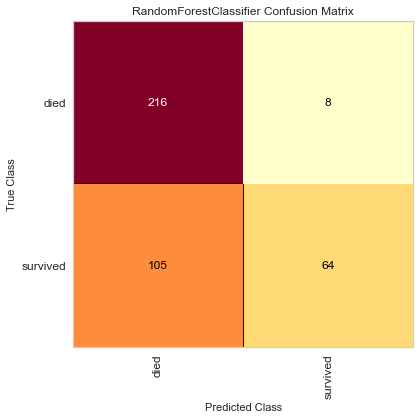

In [158]:
#Matrix de confusão
#Aqui é onde vou analisar os falsos negativos , falsos positivos e mensurar o recall
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test,y_pred)

mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(
    rf5,classes=["died","survived"], label_encoder = mapping
)

cm_viz.score(X_test, y_test)
cm_viz.poof()

fig.savefig("images/mlpr_matrix_confusion.png", dpi=300, bbox_inches="tight",)

In [160]:
#Cauculando AUC pelo SKLEARN
y_pred = rf5.predict(X_test)
roc_auc_score(y_test,y_pred)

0.6714919695688927

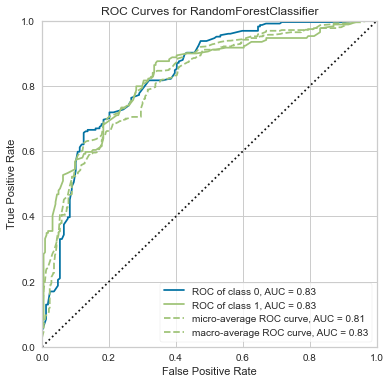

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [168]:
#Gráfico de avalicao de curva roc AUC para comparação dos classificadores
#curvas sobresalentes em relação a reta crescente do gáfico é um bom sinal
fig, ax = plt.subplots(figsize=(6,6))
rf7 = RandomForestClassifier(**{"max_features": 0.4, "n_estimators":15,"min_samples_leaf": 0.1,"random_state":42})

rf7.fit(X_train, y_train)
roc_viz = ROCAUC(rf7, is_fitted=True)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
fig.savefig("images/mlpr_rocAuc.png")
roc_viz.poof()

In [165]:
roc_viz.score(X_test, y_test)

0.833426535018429

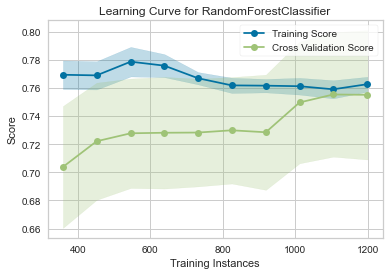

In [171]:
#Agora vamos calcular a curva de aprendizagem do modelo rf
import numpy as np
fig, ax = plt.subplots(figsize=(6,4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3,1.0,10)
lc_viz = LearningCurve(
    rf5, cv=cv, train_sizes= sizes, scoring="f1_weighted", n_jobs=4, ax = ax
)

lc_viz.fit(X,y)
lc_viz.poof()
fig.savefig("images/mlpr_lc.png")

In [174]:
#Por último a implementação do modelo
#Obs: o flask é bastante empregado para criação de inerface web para disponibilização comercial de serviços de ML
import pickle
pic = pickle.dumps(rf5)
rf8 = pickle.loads(pic)
y_pred = rf8.predict(X_test)
roc_auc_score(y_test,y_pred)
#usamos o pickle para realizar a prsistência do modelo  carregalo e depois qu tivermos o modelo
#usamos o predict para obter uma classifcação ou regressão

0.6714919695688927